In [384]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error # call it with squared=False to get RMSE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.impute import SimpleImputer
from statsmodels.regression.linear_model import OLS

# Load data

In [76]:
df = pd.read_csv("case1Data.txt", sep=', ')
df.columns = [c.replace(' ', '') for c in df.columns]


CATEGORICAL = [c for c in df.columns if c.startswith("C")]
CONTINUOUS  = [x for x in df.columns if x.startswith("x")]

# If it's understood as categorical pd.get_dummies work sensibily TOASK: should we use all overall categories or only the one in a feature
df[CATEGORICAL].astype(pd.CategoricalDtype(categories=set(df_new[CATEGORICAL].stack())))

df_new = pd.read_csv("case1Data_Xnew.txt", sep=', ') # for competition, without y
df_new.columns = [c.replace(' ', '') for c in df_new.columns]

df_new[CATEGORICAL].astype(pd.CategoricalDtype(categories=set(df_new[CATEGORICAL].stack())))

df.head()

/home/annareisz/miniconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,y,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_91,x_92,x_93,x_94,x_95,C_1,C_2,C_3,C_4,C_5
0,-6.158895,-7.518161,5.423677,11.810360,-19.076321,-7.018273,23.841339,1.050206,3.132453,4.403462,...,3.692902,12.826477,-6.889479,3.443535,5.400120,I,NaN,H,J,K
1,-22.200026,-6.370690,7.792366,11.858663,NaN,-15.420530,21.683970,1.057192,2.559764,NaN,...,7.270303,10.039281,-7.678936,-0.189822,0.717526,H,NaN,H,I,I
2,-19.357551,-4.229569,2.756115,12.446836,-17.567113,-12.984783,NaN,2.484515,NaN,1.852533,...,5.889789,14.186614,-9.527944,0.400832,-2.458897,NaN,I,K,J,G
3,28.763803,-10.487072,1.460685,9.307533,-21.306282,-19.824912,NaN,-0.442587,0.743039,-0.376102,...,7.024105,8.871258,-7.514400,-3.448892,-2.612379,K,H,I,I,NaN
4,43.779898,-13.066517,4.812794,10.641948,-17.691825,NaN,19.057921,1.900578,6.133609,-0.771247,...,8.186575,10.532577,-7.509476,NaN,0.754905,H,H,K,J,J


# Preprocess

In [342]:
def replace_missing_continouous(X: np.array):
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)
    return X
    
def replace_missing_categorical(C: np.array) -> np.array:
    imputer = SimpleImputer(strategy='most_frequent')
    C = imputer.fit_transform(C)
    return C

def fit_encoder(C, C_new, categories='auto'):
    #TOASK: should we use all overall categories or only the one in a feature. 
    # 'auto' infers categories ie. c_2 would only have two categories
    
    combined = np.concatenate((C, C_new), axis=0)
    combined = replace_missing_categorical(combined)
    
    # sparse=False to avoid sparse matrix because todense becomes "matrix" wich is deprecated with some sklearn models
    enc = OneHotEncoder(categories=categories, sparse=False) 
    enc.fit(C)
    return enc

def fit_standardizer_X(X, X_new) -> StandardScaler:
    # we should fit the standardizer before replacing missing
    # so the bias from that doesn't affect normalization
    
    combined = np.concatenate((X, X_new), axis=0)
    
    standardizer = StandardScaler()
    standardizer.fit(combined)
    
    return standardizer

def fit_standardizer_y(y):
    standardizer = StandardScaler()
    standardizer.fit(y[:, np.newaxis])
    return standardizer

def preprocess_y(df, standardizer):
    y_standard = standardizer.transform(df[['y']].values)
    return y_standard.flatten()

def preprocess_X(df, standardizer, encoder):
    X = df[CONTINUOUS].values
    C = df[CATEGORICAL].values
    
    X_nonan = replace_missing_continouous(X)
    X_standard = standardizer.transform(X_nonan)

    C_nonan = replace_missing_categorical(C)
    C_onehot = encoder.transform(C_nonan) # TOASK: any advantage in standardizing this?

    combined = np.concatenate((X_standard, C_onehot), axis=1)

    return combined

# example use - in practice we must preprocess within the fold!
standardizer = fit_standardizer(df[CONTINUOUS].values, df_new[CONTINUOUS].values)
encoder = fit_encoder(df[CATEGORICAL].values, df_new[CATEGORICAL].values)
X_train = preprocess_X(df, standardizer, encoder)

standardizer = fit_standardizer_y(df['y'].values)
y_train = preprocess_y(df, standardizer)
print('done')

done


# Model selection

In [358]:
N = len(df)
K = 5

In [467]:
num_ridge_lambdas = 100
ridge_lambdas = np.logspace(-4, 4, num_ridge_lambdas)


RMSE = {'OLS'  : np.zeros(K),
        'Ridge': np.zeros((K, num_ridge_lambdas)),
        'KNN': None # Anna
        'Weighted KNN': None # Anna
        'Lasso': None # Tymek,
        'Elastic Net': None # Tymek
       }

fold_idxs = np.arange(0, N)%K
fold_idxs = np.random.permutation(fold_idxs) #shuffle

for i in range(K):
    # split
    df_train = df.loc[fold_idxs !=i]
    df_test = df.loc[fold_idxs == i]
    
    # prep
    standardizer_X = fit_standardizer_X(df_train[CONTINUOUS].values, df_new[CONTINUOUS].values)
    encoder        = fit_encoder(df[CATEGORICAL].values, df_new[CATEGORICAL].values)
    
    X_train = preprocess_X(df_train, standardizer_X, encoder)
    X_test  = preprocess_X(df_test, standardizer_X, encoder)
    
    standardizer_y = fit_standardizer_y(df_train['y'].values)
    
    y_train = preprocess_y(df_train, standardizer_y)
    y_test  = preprocess_y(df_test, standardizer_y)
    
    # model 
    ols = LinearRegression(fit_intercept=False).fit(X_train, y_train)
    y_pred = ols.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    RMSE['OLS'][i] = rmse
    
    for j in range(num_ridge_lambdas):
        ridge = Ridge(alpha=ridge_lambdas[j], fit_intercept=False).fit(X_train, y_train)
        y_pred = ridge.predict(X_test)
    
        RMSE['Ridge'][i, j] = mean_squared_error(y_test, y_pred, squared=False)
    
    
    
    

In [468]:
RMSE['Ridge'][:, best_lambda_ridge_idx]

array([0.5590387 , 0.78414618, 0.6075048 , 0.62426304, 0.85872893])

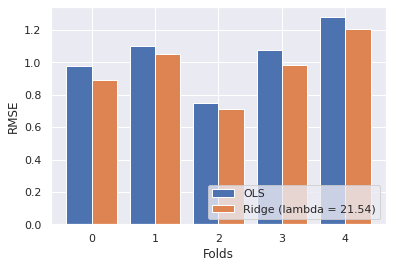

In [469]:
best_lambda_ridge_idx = RMSE['Ridge'].mean(axis=0).argmin()
plt.bar(np.arange(K)-0.2, RMSE['OLS'], label='OLS', width=0.4)
plt.bar(np.arange(K)+0.2, RMSE['Ridge'][:, 42], label=f'Ridge (lambda = {ridge_lambdas[best_lambda_ridge_idx].round(2)})', width=0.4)
plt.xlabel("Folds")
plt.xticks(np.arange(K))
plt.ylabel("RMSE")
plt.legend(loc='lower right')
plt.show()

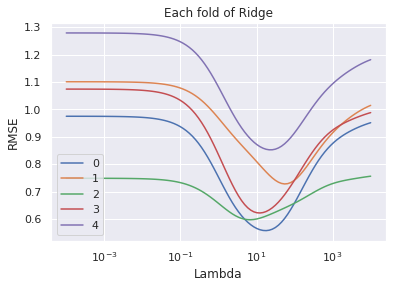

In [485]:
plt.figure()
plt.title("Each fold of Ridge")
plt.semilogx(ridge_lambdas, RMSE['Ridge'].T, label=np.arange(K))
plt.ylabel("RMSE")
plt.xlabel("Lambda")
plt.legend()
plt.show()

### Fuck statmodels. It depends on old pandas

In [383]:
def add_intercept(X):
    return np.concatenate((np.ones((len(X), 1)), X), axis=1)

regr = OLS(y_train.tolist(), add_intercept(X_train)).fit()
print(regr.aic)

regr = OLS(y_train.tolist(), X_train).fit()
print(regr.aic)

regr.predict(y_test)

-5013.827741613151
-4946.2176531445


AttributeError: module 'pandas' has no attribute 'Panel'